Oracle Data Science service sample notebook.

Copyright (c) 2022 Oracle, Inc. All rights reserved. Licensed under the [Universal Permissive License v 1.0](https://oss.oracle.com/licenses/upl).

***

# <font color="red">Feature Type Tutorial</font>
<p style="margin-left:10%; margin-right:10%;">by the <font color="teal">Oracle Cloud Infrastructure Data Science Service.</font></p>

***

# Overview:

There is a distinction between the data type of a feature and the nature of data that it represents. The data type represents the form of the data that the computer understands. ADS uses the term "feature type" to refer to the nature of the data. For example, a medical record id could be represented as an integer, its data type, but the feature type would be "medical record id". The feature type represents the data the way the data scientist understands it. ADS provides the feature type module on top of your Pandas dataframes and series to manage and use the typing information to better understand your data.

The feature type framework comes with some common feature types. However, the power of using feature types is that you can easily create your own and apply them to your specific data. You don't need to try to represent your data in a synthetic way that does not match the nature of your data. This framework allows you to create methods that validate whether the data fits the specifications of your organization. For example, for a medical record type you could create methods to validate that the data is properly formatted. You can also have the system generate warnings to sure the data is valid as a whole or create graphs for summary plots.

The framework allows you to create and assign multiple feature types. For example, a medical record id could also have a feature type id and the integer feature type.

---

## Contents:

- <a href='#intro'>Introduction</a>
- <a href="#feature_type">Feature Type</a>
    - <a href="#set_feature_type">Setting Feature Types</a>
        - <a href="#set_feature_type_series">Series</a>
        - <a href="#set_feature_type_df">Dataframe</a>
    - <a href="#default_type">Default Feature Type</a>
    - <a href="#tag">Tag</a>
- <a href="#feature_select">Feature Type Selection</a>
- <a href='#feature_count'>Feature Count</a>
- <a href='#feature_stat'>Feature Statistics</a>
- <a href="#correlation">Correlation</a>
    - <a href="#correlation_pearson">Pearson Correlation Coefficient</a>
    - <a href="#correlation_correlation_ratio">Correlation Ratio</a>
    - <a href="#correlation_cramers_v">Cramér's V</a>
- <a href='#plots'>Feature Plot</a>
- <a href="#warnings">Feature Type Warnings</a>
    - <a href="#validating_data">Validating Data</a>
    - <a href="#examining">Examining Feature Type Warnings</a>
    - <a href="#register_unregister">Register and Unregistering a Feature Type Warning</a>
        - <a href="#register">Register a Feature Type Warning</a>
        - <a href="#unregister">Unregister a Feature Type Warning</a>
    - <a href="#dataframe">Working with a DataFrame</a>
- <a href='#overview'>Feature Type Validators</a>
    - <a href="#list_validators">List Feature Type Validator</a>
        - <a href="#list_validators_ftm">List Feature Type Validators Using the Feature Type Manager</a>
        - <a href="#list_validators_fto">List Feature Type Validators on a Feature Type Object</a>
        - <a href="#list_validators_series">List Feature Type Validators on a Series</a>
        - <a href="#list_validators_df">List Feature Type Validators on a Dataframe</a>
    - <a href="#using_handlers">Using Feature Type Validators</a>
        - <a href="#using_handlers_series">Using Feature Type Validators on a Series</a>
        - <a href="#using_handlers_fto">Using Feature Type Validators on a Feature Type Object</a>
    - <a href="#default_handler">Default Feature Type Validator</a>
        - <a href="#create_handler">Create a Default Feature Type Validator</a> 
        - <a href='#validator_register'>Registering a Default Feature Type Validator</a>
    - <a href='#condition_handler'>Condition Feature Type Validator</a>
        - <a href='#condition_handler_closed'>Closed Value Condition Feature Type Validator</a>   
        - <a href='#condition_handler_open'>Open Value Condition Feature Type Validator</a>
        - <a href='#condition_handler_disambiguation'>Disambiguation</a>
    - <a href='#unregistering'>Unregistering a Feature Type Validator</a>  
- <a href="#feature_type_create">Create a Custom Feature Type</a>
    - <a href="#feature_type_register">Register a Custom Feature Type</a>
    - <a href="#feature_type_attributes">Attributes</a>
    - <a href="#feature_type_stats">Feature Type Statistics</a>
    - <a href="#feature_type_plot">Feature Type Plot</a>
    - <a href="#feature_type_method">Custom Method in a Feature Type Class</a>
    - <a href='#unregister_custom_type'>Unregistering a Custom Feature Type</a>
- <a href="#reference">References</a>

---

<font color="gray">
Datasets are provided as a convenience.  Datasets are considered third-party content and are not considered materials 
under your agreement with Oracle.

You can access the `orcl_attrition` dataset license [here](https://oss.oracle.com/licenses/upl). 
</font>

In [1]:
import ads
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns

from ads.common.card_identifier import card_identify
from ads.dataset.dataset_browser import DatasetBrowser
from ads.feature_engineering import feature_type_manager, FeatureType, Tag
from os import path

<a id="intro"></a>
# Introduction

The feature type system allows data scientists to separate the concept of how data is represented physically from what the data actually measures. That is, the data can have feature types that classify the data based on what it represents and not how the data is stored in memory. Each set of data can have multiple feature types through a system of multiple inheritances. As a concrete example, an organization that sells cars might have a set of data that represents their purchase price of a car, that is the wholesale price. You  could have a feature set of `wholesale_price`, `car_price`, `USD`, and `continuous`. 

All default feature types have methods for creating summary statistics and a plot to represent the data. This allows you to have summary information for each feature of your dataset while only using a single command. However, the default feature types may not provide the exact details needed in your specific use case. Therefore, feature types have been designed with expandability in mind. When creating a new feature type, the summary statistics and plots that are specific to your feature type can be customized.

The feature type system works at the Pandas dataframe and series levels. This allows you to create summary information across all of your data and at the same time dig into the specifics of one feature.

The `.feature_count()` method returns a dataframe that provides a summary of the number of features in a dataframe. Each row represents a feature type. It provides a count of the number of times that feature type is used in the dataframe. It also provides a count of the number of times that the feature type was the primary feature type. The primary feature type is the feature type that has no children feature types.

The `.feature_stat()` method returns a dataframe where each row represents a summary statistic and the numerical value for that statistic.

The `.feature_plot()` method returns a Seaborn plot object that summaries the feature. It can be modified after it is returned so that you can customize it to fit your needs.

There are also a number of correlation methods such as `.correlation_ratio()`, `.pearson()`, and `.cramersv()` that provide information about the correlation between different features in the form of a dataframe. Each row represents a single correlation metic. This information can also be represented in a plot with the `.correlation_ratio_plot()`, `.pearson_plot()`, and `.cramersv_plot()` methods.

Feature type warnings are used for rapid validation of the data. For example, the `wholesale_price` might have a method that ensures that the value is a positive number because you can't purchase a car with negative money. The `car_price` feature type may have a check to ensure that it is within a reasonable price range. `USD` can check the value to make sure that it represents a valid US dollar amount. It can't have values below one cent. The `continuous` feature type is the <a href="default_type">default feature type</a> and it represents the way the data is stored internally.

The feature type validators are a set of `is_*` methods, where `*` is generally the name of the feature type. For example, the method `.is_wholesale_price()` can create a boolean Pandas series that indicates what values meet the validation criteria. It  allows you to quickly identify which values need to be filtered or require future examination into problems in the data pipeline. The feature type validators can be as complex as they need to be. For example, they might take a client ID and call an API to validate each client ID is active.

The feature type manager provides the tools to manage the handlers that are used to drive this system. The system works by creating functions that are then registered as feature type validators or warnings. The role of `feature_type_manager` is to provide the interface to manage these handlers.

A feature type has the following attributes that can be overridden:

- `description`: A description of the feature type.
- `name`: The name of the feature type.

If you wish to create custom summary statistics for a feature type, then override the `.feature_stat()` method. To create a custom summary plot, override the `.feature_plot()` method.

<a id="feature_type"></a>
# Feature Type

Pandas dtypes are physical data types that indicate how data are stored. You can call `.dtype` on your Pandas dataframe or series to inspect the physical types. Feature types are the logical types that define how the data should be interpreted by the end user. Feature types categorize the features from the machine learning perspective. Different feature types could be the same physical type. For example, both categorical and ordinal can be an integer dtype. However, the difference between `categorical` and `ordinal` feature types is that `ordinal` features have an ordering while `categorical` features don't. 

ADS allows a set of data to have multiple feature types through a system of inheritance. For example, a hospital may have a medical record number for each patient. That data might have the feature types `patient_id`, `id`, and `integer`. The `patient_id` is the child feature type with `id` being its parent. The `integer` is the parent of the `id` feature type. It is also the last feature type in the inheritance chain and is called the <a href="default_type">default feature type</a>.

In addition to the regular feature types, there are two special versions. The <a href="default_type">default type</a> is based on the Pandas dtype and cannot be changed without changing the Pandas dtype. There is no need to set it because it is always the last feature type in the inheritance chain. The <a href="#tags">tag</a> feature type does not support <a href="#warnings">feature type warning</a> nor <a href="#handlers">feature type validators</a>. It is designed to allow you to tag data with extra information.

Calling `feature_type_manager.feature_type_registered()`, gives you an overview of all the registered feature types. ADS comes with various common feature types, but the idea is that you create feature types that explicitly define your data.

`feature_type_manager.feature_type_registered()` returns a dataframe with these columns:
- `Class`: registered feature type class.
- `Name`: feature type class name.
- `Description`: Description of each feature type class.

In [2]:
feature_type_manager.feature_type_registered()

,Class,Name,Description
0,ADSString,ads_string,Type representing enhanced string class.
1,Address,address,Type representing address.
2,Boolean,boolean,Type representing binary values True/False.
3,Category,category,Type representing discrete unordered values.
4,Constant,constant,Type representing constant values.
5,Continuous,continuous,Type representing continuous values.
6,CreditCard,credit_card,Type representing credit card numbers.
7,DateTime,date_time,Type representing date and/or time.
8,Discrete,discrete,Type representing discrete values.
9,Document,document,Type representing document values.


<a id="set_feature_type"></a>
## Setting Feature Types
    
The `.feature_type` property is used to store the feature types that are to be associated with a dataset. It accepts an ordered list of the feature types that are to be associated with the dataset. The next cell creates a series of credit card numbers. It then uses the `.feature_type` with a list of strings of the class names of the feature types. 

A call to `.feature_type_description` returns a dataframe that is ordered by inheritance. It contains the following columns:

* `Feature Type`: The class that defines the feature type.
* `Description`: A description of the feature type.


<a id="set_feature_type_series"></a>
### Series

To assign feature types to a Pandas series us the `.ads.feature_type` property on the series.


In [3]:
series = pd.Series(["4532640527811543", "4556929308150929", "4539944650919740", "4485348152450846"], name='Credit Card')
series.ads.feature_type = ['credit_card', 'string']
series.ads.feature_type_description

,Feature Type,Description
0,credit_card,Type representing credit card numbers.
1,string,Type representing string values.


The `.feature_type` property doesn't have to take the class name because it can accept the class itself. For example, the feature type object that is associated with the `credit_card` class name can be used. This gives you flexibility for how you want to define the feature types.

The feature type manager can be used to get a `FeatureType` object that is based on the `credit_card` feature type. You do this with the `.feature_type_object()` method.

You can repeat the preceding example by replacing `credit_card` with `CreditCard` and obtain the same results.

In [4]:
CreditCard = feature_type_manager.feature_type_object('credit_card')
series.ads.feature_type = [CreditCard, 'string']
series.ads.feature_type

['credit_card', 'string']

The `.feature_type_object()` method, of the `feature_type_manager` object, takes a class name and return as object based on `FeatureType`. This object represents the feature type. For example, 'string' is the class name of the feature type `String`. The next cell checks if the class is a subclass of `FeatureType`.

In [5]:
String = feature_type_manager.feature_type_object('string')
issubclass(String, FeatureType)

True

Now use the `String` and the `CreditCard` class to set the feature types:

In [6]:
series.ads.feature_type = [CreditCard, String]
series.ads.feature_type

['credit_card', 'string']

<a id="set_feature_type_df"></a>
### Dataframe

Like a Pandas series, `.feature_type` can be used on a dataframe to set the feature types for the columns in the dataframe. The property accepts a dictionary where the key in the dictionary is the column name and the value is a list of feature types associated with that column.

In [7]:
attrition_path = os.path.join('/opt', 'notebooks', 'ads-examples', 'oracle_data', 'orcl_attrition.csv')
df = pd.read_csv(attrition_path, 
                 usecols=['Attrition', 'TravelForWork', 'JobFunction', 'EducationalLevel'])
df.ads.feature_type = {'Attrition': ['boolean', 'category'],
                       'TravelForWork': ['category'],
                       'JobFunction': ['category'],
                       'EducationalLevel': ['category']}
df.ads.feature_type_description

,Column,Feature Type,Description
0,Attrition,boolean,Type representing binary values True/False.
1,Attrition,category,Type representing discrete unordered values.
2,Attrition,string,Type representing string values.
3,TravelForWork,category,Type representing discrete unordered values.
4,TravelForWork,string,Type representing string values.
5,JobFunction,category,Type representing discrete unordered values.
6,JobFunction,string,Type representing string values.
7,EducationalLevel,category,Type representing discrete unordered values.
8,EducationalLevel,string,Type representing string values.


<a id="default_type"></a>
## Default Feature Type

There is a special feature type called the default feature type. It is based on the Pandas dtype. It doesn't have to be set by the user, but it can be.

Feature types allow for multiple inheritances and the default feature type is an ancestor to all other feature types, with the exception of <a href="#tags">tags</a>. Each series only has one default feature type. It can't be mutated or removed unless the underlying Pandas dtype has changed. For example, you have a Pandas series called `series` that has a dtype of `string` so its default feature type is `string`. If you change the type by calling `series = series.astype('category')`, then the default feature type is `categorical` instead of `string`.

ADS automatically detects the dtype of each series and sets the default feature type. The default feature type can be one of the following:

- `boolean`
- `date_time`
- `category`
- `string`
- `continuous`
- `integer`
- `object`.

The next cell creates a Pandas series of credit card numbers and prints the default feature type:

In [8]:
series = pd.Series(["4532640527811543", "4556929308150929", "4539944650919740"], name='creditcard')
series.ads.default_type

'string'

The `.feature_type` property allows you to list the feature types that are assigned to the data. In the next cell, `series` has the `credit_card` feature type added and the feature types are displayed. Notice that the `string` feature type is the last in the list and it wasn't included in the `.feature_type` property. This is because it is the default feature type and it's included automatically.

In [9]:
series.ads.feature_type = ['credit_card']
series.ads.feature_type

['credit_card', 'string']

The default feature type can be included in the `.feature_type` property. If you do that, then the default feature type isn't added a second time.

In [10]:
series.ads.feature_type = ['credit_card', 'string']
series.ads.feature_type

['credit_card', 'string']

<a id="tag"></a>
## Tag

A non-tag feature type must have a Python class defined and registered with ADS. However, it is often convenient to tag a dataset with additional information without the need to create a feature type class. This is the role of the `Tag`, which allows you to create a feature type without having to explicitly define and register a class. The tradeoff is that you can't have <a href="#warnings">feature type warnings</a> nor <a href="#handlers">feature type validators</a>. Tags are semantic and provide more context about the actual meaning of a feature. This could directly affect the interpretation of the information. Tags are optional for any dataset.

The process of creating your tag is the same as setting the feature types because it is a feature type. You use the `.feature_type` property to create tags. 

The next cell creates a set of credit card numbers and set the feature type to `credit_card` and tags the dataset as being inactive cards. Also the cards are from North American financial institutions. You can put any text ypu want in the `Tag()` because no underlying feature type class has to exist.

In [11]:
series = pd.Series(["4532640527811543", "4556929308150929", "4539944650919740", "4485348152450846"], name='Credit Card')
series.ads.feature_type=['credit_card', Tag('Inactive Card'), Tag('North American')]
series.ads.feature_type

['credit_card', 'string', 'Inactive Card', 'North American']

Tags are always listed after the other feature types.

In [12]:
series.ads.feature_type = [Tag('Inactive Card'), 'credit_card', Tag('North American')]
series.ads.feature_type

['credit_card', 'string', 'Inactive Card', 'North American']

A list of tags can be obtained using the `tags` attribute.

In [13]:
series.ads.tags

['Inactive Card', 'North American']

<a id="feature_select"></a>
# Feature Type Selection

You can select a subset of columns based on the feature types using `feature_select`. 
- `include` defaults to `None`. It takes a list of feature types (feature type object or feature type name) to include in the returned dataframe.
- `exclude` defaults to `None`. It takes a list of feature types (feature type object or feature type name) to exclude from the returned dataframe. 
- `include` and `exclude` cannot both be `None`. A feature type cannot be included or excluded at the same time.

Next, create a dataframe that only has columns that have a boolean feature type:

In [14]:
df.ads.feature_select(include=['boolean'])

,Attrition
0,Yes
1,No
2,Yes
3,No
4,No
...,...
1465,No
1466,No
1467,No
1468,No


Now, create a dataframe that excludes columns that have a boolean feature type:

In [15]:
df.ads.feature_select(exclude=['boolean'])

,TravelForWork,JobFunction,EducationalLevel
0,infrequent,Product Management,L2
1,often,Software Developer,L1
2,infrequent,Software Developer,L2
3,often,Software Developer,L4
4,infrequent,Software Developer,L1
...,...,...,...
1465,often,Software Developer,L2
1466,infrequent,Software Developer,L1
1467,infrequent,Software Developer,L3
1468,often,Product Management,L3


<a id='feature_count'></a>
# Feature Count

Each column in a Pandas dataframe is associated with at least one feature type. This would be the default feature type and it is determined by the Pandas dtype. However, the feature type system allows you to associate a feature with multiple feature types using a system of inheritance. As discussed in the <a href='#overview'>Feature Type System</a> section, a feature could have a feature set of `wholesale_price`, `car_price`, `USD`, and `continuous`.

The `.feature_count()` method can be called on a dataframe to provide a summary of what features are being used. The output is a dataframe where each row represents a feature type and that is listed in the Feature Type column. The next column lists the number of times the feature type appears in any of the columns. Since each feature can have multiple feature types it counts all occurrences. The next column, Primary, is the count of the number of times that the feature type is listed as the primary feature type. That is the feature type that has no subclasses.

The `.feature_count()` provides a summary of what features are being used across all features in the dataframe. The output dataframe has one row for each feature type that is represented in the dataframe. This is listed in the Feature Type column. The next column lists the number of times the feature type appears in any of the columns. For example, the category feature type appears in the Attrition, TravelForWork, and JobFunction columns. Therefore, it has a count of three. The Primary column is the count of the number of times that the feature type is listed as the primary feature type. For the category feature type, the value is two as TravelForWork and JobFunction have this as their primary feature type. While category is a feature type of Attrition, it is not the primary feature type, boolean is. In the case of the string feature type, it occurs in the Attrition, TravelForWork and JobFunction features, however, it is not the primary feature type in these features and thus its Count is 3 but its Primary count is 0.

In [16]:
attrition_path = os.path.join('/opt', 'notebooks', 'ads-examples', 'oracle_data', 'orcl_attrition.csv')
df = pd.read_csv(attrition_path, 
                 usecols=['Attrition', 'TravelForWork', 'JobFunction', 'TrainingTimesLastYear'])
df.ads.feature_type = {'Attrition': ['boolean', 'category'],
                         'TravelForWork': ['category'],
                         'JobFunction': ['category'],
                         'TrainingTimesLastYear': ['integer']}
df.head()

,Attrition,TravelForWork,JobFunction,TrainingTimesLastYear
0,Yes,infrequent,Product Management,0
1,No,often,Software Developer,3
2,Yes,infrequent,Software Developer,3
3,No,often,Software Developer,3
4,No,infrequent,Software Developer,3


In [17]:
df.ads.feature_count()

,Feature Type,Count,Primary
0,boolean,1,1
1,category,3,2
2,string,3,0
3,integer,1,1


<a id='feature_stat'></a>
# Feature Statistics

One of the main goals of the EDA is to gain an understanding of the nature of your data. Computing summary statistics is one of the most common tasks in this process. The goal of the `.feature_stat()` method is to produce relevant summary statistics for the feature set. The feature type framework allows you to customize what statistics will be used in a feature type.

The `.feature_stat()` outputs a Pandas dataframe where each row represents a summary statistic. The statistics that are reported depend on the multiple inheritance of the feature types. The feature type framework will iterate from the primary feature type to the default feature type looking for a feature type that has the `.feature_stat()` method defined and then will dispatch on that.

In the next cell, the `.feature_stat()` for the integer feature type is run. This feature set will return the count of the observations, the mean value, the standard deviation and <a href="https://en.wikipedia.org/wiki/Five-number_summary">Tukey's Five Numbers</a> (sample minimum, lower quartile, median, upper quartile, and sample maximum).

In [18]:
df['TrainingTimesLastYear'].ads.feature_stat()

,Metric,Value
0,count,1470.000000
1,mean,2.799320
2,standard deviation,1.289271
3,sample minimum,0.000000
4,lower quartile,2.000000
5,median,3.000000
6,upper quartile,3.000000
7,sample maximum,6.000000


The summary statistics that are created depend on the feature type. For example, the JobFunction column is categorical so it produces a count of the number of observations and the number of unique categories.

In [19]:
df['JobFunction'].ads.feature_stat()

,Metric,Value
0,count,1470
1,unique,3


This may not be ideal summary for the JobFunction feature. Instead, you may want to know the number of job functions in each category. This can be done by creating a new feature type and its associated `.feature_stat()` method. In next cell, a new feature type called `JobFunction` is created. It overrides the `.feature_stat()` method to produce a count of the number of each job functions in the data. This feature type is then registered and the JobFunction column, in the dataframe, is updated so that it now inherits from the `JobFunction` feature type. Then it prints the feature summary statistics for the JobFunction column.

In [20]:
try: # remove the feature type if it is already registered
    feature_type_manager.feature_type_unregister(JobFunction)
except:
    pass

# Create the JobFunction feature type
class JobFunction(FeatureType):
    @staticmethod
    def feature_stat(series: pd.Series) -> pd.DataFrame:
        result = dict()
        job_function = ['Product Management', 'Software Developer', 'Software Manager', 'Admin', 'TPM']
        for label in job_function:
            result[label] = len(series[series == label])
        return pd.DataFrame.from_dict(result, orient='index', columns=[series.name])

# Register the JobFunction feature type and assign it to the dataframe    
feature_type_manager.feature_type_register(JobFunction)
df['JobFunction'].ads.feature_type = ['job_function', 'category']
df['JobFunction'].ads.feature_stat()

,Metric,Value
0,Product Management,446
1,Software Developer,961
2,Software Manager,0
3,Admin,63
4,TPM,0


The `.feature_stat()` method also works at the dataframe level. It will produce a similar output to the output for the series, except it will have an additional column that lists the column name where the metric was computed.

In [21]:
df.ads.feature_stat()

,Column,Metric,Value
0,Attrition,count,1470.000000
1,Attrition,unique,2.000000
2,TravelForWork,count,1470.000000
3,TravelForWork,unique,3.000000
4,JobFunction,Product Management,446.000000
5,JobFunction,Software Developer,961.000000
6,JobFunction,Software Manager,0.000000
7,JobFunction,Admin,63.000000
8,JobFunction,TPM,0.000000
9,TrainingTimesLastYear,count,1470.000000


<a id="correlation"></a>
# Correlation

Generally, a data scientist wants to make a model as parsimonious as possible. This often involves determining what features are highly correlated and removing some of them. While some models such as decision trees are not sensitive to correlated variables, other ones such as ordinary least squares regression are. You may also want to remove correlated variables at it reduces the cost of collecting and processing the data.

The EDA features in ADS speed up your analysis by providing methods to compute different types of correlations. There are several different correlation techniques provided as they have different use cases. Further, there are two sets of methods. One method returns a dataframe with the correlation information and it has a partner method that generates a plot.

What correlation technique you use depends on the type of data that you are working with. When using these correlation techniques you will need to slice your dataframe so that only the appropriate feature types are used in the calculation. The following is a summary of the different correlation techniques and what data should be used.
* `pearson`: The <a href="https://en.wikipedia.org/wiki/Pearson_correlation_coefficient">Pearson correlation coefficient</a> is a normalized measure of the covariance between two sets of data. In essence, it measures the linear correlation between the datasets. This method is used when both datasets consist of continuous values.
* `correlation_ratio`: The <a href="https://en.wikipedia.org/wiki/Correlation_ratio">Correlation ratio</a> measures the extent to which a distribution is spread out within individual categories relative to the spread of the entire population. This metric is used to compare categorical variables to continuous values.
* `cramersv`: The <a href="https://en.wikipedia.org/wiki/Cram%C3%A9r%27s_V">Cramér's V</a> provides a measure of the degree of association between two categorical/nominal datasets.

<a id="correlation_pearson"></a>
## Pearson Correlation Coefficient

The <a href="https://en.wikipedia.org/wiki/Pearson_correlation_coefficient">Pearson correlation coefficient</a> is known by a number of names such as Pearson's r, Pearson product moment correlation coefficient, bivariate correlation or the correlation coefficient. It has a range of [-1, 1] where 1 means that the two datasets are perfectly correlated and a value of -1 means that the correlation is perfectly out of phase. Thus, when one dataset is increasing the other one is decreasing.

The Pearson correlation coefficient is a normalized value of the covariance between the continuous datasets X and Y. It is normalized by the product of the standard deviation between X and Y and is given by the following formula:
$$\rho_{X,Y} = \frac{cov(X,Y)}{\sigma_X \sigma_Y}$$

In [22]:
df = pd.read_csv(attrition_path,
                usecols=['Age', 'YearsinIndustry', 'YearsOnJob', 'YearsWithCurrManager', 'YearsAtCurrentLevel'])
df.ads.feature_type = {'Age': ['continuous'], 'YearsinIndustry': ['continuous'], 'YearsOnJob': ['continuous'], 
                     'YearsWithCurrManager': ['continuous'], 'YearsAtCurrentLevel': ['continuous']}
df.ads.pearson()

,Column 1,Column 2,Value
0,Age,Age,1.0000
1,Age,YearsinIndustry,0.6804
2,Age,YearsOnJob,0.3113
3,Age,YearsAtCurrentLevel,0.2129
4,Age,YearsWithCurrManager,0.2021
5,YearsinIndustry,Age,0.6804
6,YearsinIndustry,YearsinIndustry,1.0000
7,YearsinIndustry,YearsOnJob,0.6281
8,YearsinIndustry,YearsAtCurrentLevel,0.4604
9,YearsinIndustry,YearsWithCurrManager,0.4592


This same information can be represented in a plot using the `.pearson_plot()` method.

<AxesSubplot:title={'center':"Pearson's Correlation"}>

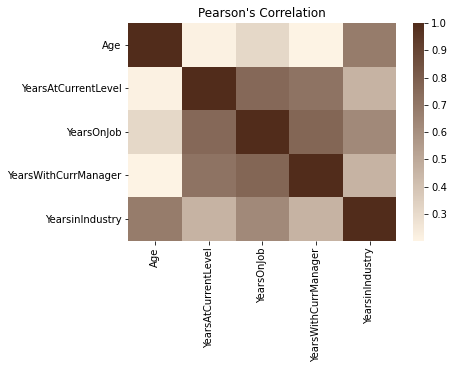

In [23]:
df.ads.pearson_plot()

<a id="correlation_correlation_ratio"></a>
## Correlation Ratio

Statistical dispersion, or scatter, is a measure of the spread of a distribution with variance being a common metric. The <a href="https://en.wikipedia.org/wiki/Correlation_ratio">Correlation ratio</a> is a measure of dispersion with categories relative to the dispersion across the entire dataset. The Correlation ratio is a weighted variance of the category means over the variance of all samples. It is given by the formula:
$$\eta = \sqrt{\frac{\sigma_{\bar{y}}^2}{\sigma_y^2}}$$

where:
$$\sigma_{\bar{y}}^2 = \frac{\sum_x n_x(\bar{y}_x - \bar{y})^2}{\sum_x n_x}$$
$$\sigma_{y}^2 = \frac{\sum_{x,i} n_x(\bar{y}_{x,i} - \bar{y})^2}{n}$$

where $n$ is the total number of observations and $n_x$ is the number of observations in a category $x$. $\bar{y}_x$ is the mean value in category $x$ and $\bar{y}$ is the overall mean.

Values of $\eta$ near zero indicate that there is no dispersion between the means of the different categories. A value of $\eta$ near one suggests that there in no dispersion within the respective categories.

In [24]:
df = pd.read_csv(attrition_path,
                usecols=['JobFunction', 'Age', 'YearsinIndustry', 'YearsOnJob', 'YearsWithCurrManager', 'YearsAtCurrentLevel'])
df.ads.feature_type = {'Age': ['continuous'], 'YearsinIndustry': ['continuous'], 'YearsOnJob': ['continuous'], 
                     'YearsWithCurrManager': ['continuous'], 'YearsAtCurrentLevel': ['continuous'],
                      'JobFunction': ['category']}
df.ads.correlation_ratio()

,Column 1,Column 2,Value
0,Age,Age,1.0000
1,Age,JobFunction,0.0323
2,JobFunction,Age,0.0323
3,JobFunction,JobFunction,1.0000
4,JobFunction,YearsAtCurrentLevel,0.0580
5,JobFunction,YearsOnJob,0.0322
6,JobFunction,YearsWithCurrManager,0.0361
7,JobFunction,YearsinIndustry,0.0158
8,YearsAtCurrentLevel,JobFunction,0.0580
9,YearsAtCurrentLevel,YearsAtCurrentLevel,1.0000


<AxesSubplot:title={'center':'Correlation Ratio'}>

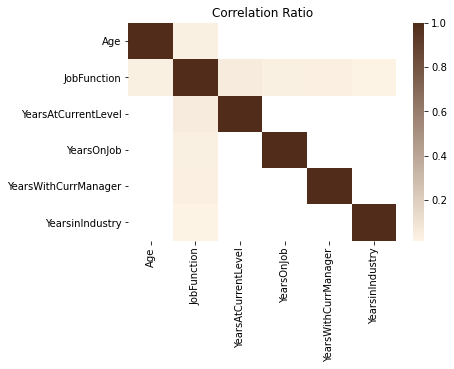

In [25]:
df.ads.correlation_ratio_plot()

<a id='target'></a>

<a id="correlation_cramers_v"></a>
## Cramér's V

<a href="https://en.wikipedia.org/wiki/Cram%C3%A9r%27s_V">Cramér's V</a> is used to measure the amount of association between two categorical/nominal variables. A value of zero means that there is no association between the bivariates and a value of one means that there is complete association. $V$ is the percentage of the maximum association between the variables, which is dependent on the frequency in which the tuples $(x_i, y_j)$ occur.

The value of $V$ is related to the chi-squared statistic, $\Chi^2$ and is given by:
$$V = \sqrt{\frac{\Chi^2}{min(k-1, r-1)n}}$$

where: $k$ and $r$ are the number of categories in the datasets $x$ and $y$. $n$ is the sample size.


In [26]:
df = pd.read_csv(attrition_path,
                 usecols=['TravelForWork', 'JobFunction', 'EducationField', 'EducationalLevel'])
df.ads.feature_type = {'TravelForWork': ['category'], 'JobFunction': ['category'], 'EducationField': ['category'], 
                     'EducationalLevel': ['category']}
df.ads.cramersv()

,Column 1,Column 2,Value
0,EducationField,EducationField,1.0000
1,EducationField,EducationalLevel,0.0552
2,EducationField,JobFunction,0.5880
3,EducationField,TravelForWork,0.0000
4,EducationalLevel,EducationField,0.0552
5,EducationalLevel,EducationalLevel,1.0000
6,EducationalLevel,JobFunction,0.0000
7,EducationalLevel,TravelForWork,0.0000
8,JobFunction,EducationField,0.5880
9,JobFunction,EducationalLevel,0.0000


<AxesSubplot:title={'center':"Cramer's V"}>

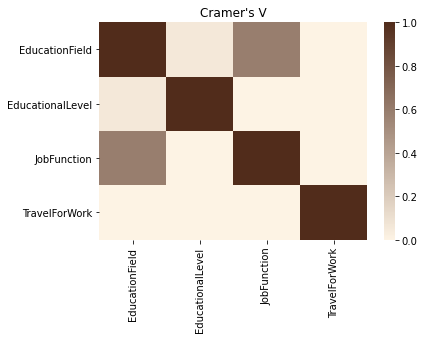

In [27]:
df.ads.cramersv_plot()

<a id='plots'></a>
# Feature Plot

Visualization of a dataset is a quick way to gain insights into the distribution of values. The feature type system in ADS provides plots for all ADS-supported feature types. However, it is easy to create feature plots for your custom feature types. Calling `.feature_plot()` on a Pandas series will produce a univariate plot. The next cell produces a bar chart with a count of the number of employees and how often they travel.

<AxesSubplot:xlabel='Count', ylabel='TravelForWork'>

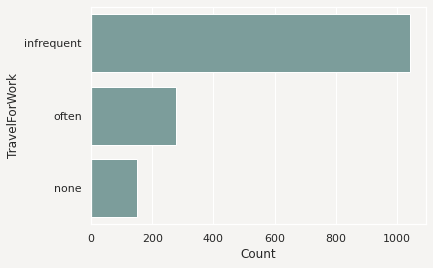

In [28]:
df = pd.read_csv(attrition_path, 
                usecols=['Attrition', 'TravelForWork', 'JobFunction', 'TrainingTimesLastYear'])
df.ads.feature_type = {'Attrition': ['category'], 'TravelForWork': ['category'],
                       'JobFunction': ['category'], 'TrainingTimesLastYear': ['continuous']}
df['TravelForWork'].ads.feature_plot()

The `feature_plot()` method on a Pandas series returns a `matplotlib.pyplot` object. This allows you to modify the plot to customize it further. The next cell will capture the plot and add a title.

Text(0.5, 1.0, 'Count of the Number of Employees and How Much they Travel')

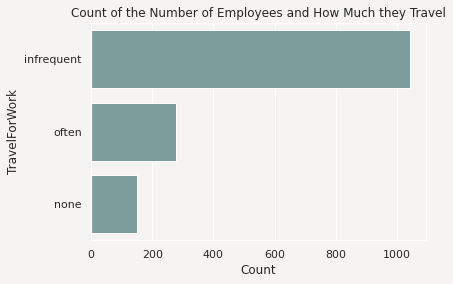

In [29]:
travel_plot = df['TravelForWork'].ads.feature_plot()
travel_plot.set_title("Count of the Number of Employees and How Much they Travel")

It is often expedient to produce the feature plots for all the features in the dataframe. This can be done by calling `.feature_plot()` on the dataframe. It will return a dataframe where each row represents a feature. There are two columns, `Column` which is the name of the column and `Plot` which is the plot object.

,Column,Plot
0,Attrition,"AxesSubplot(0.125,0.125;0.775x0.755)"
1,TravelForWork,"AxesSubplot(0.125,0.125;0.775x0.755)"
2,JobFunction,"AxesSubplot(0.125,0.125;0.775x0.755)"
3,TrainingTimesLastYear,"AxesSubplot(0.125,0.125;0.775x0.755)"


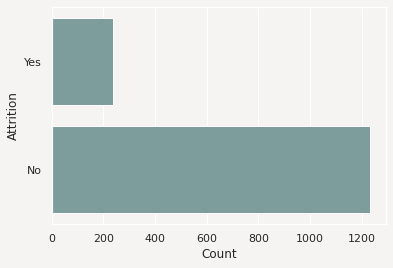

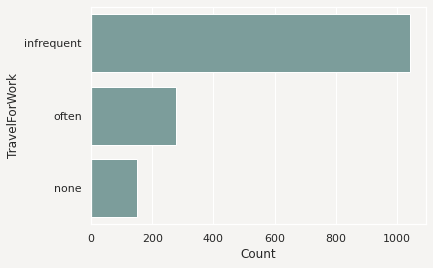

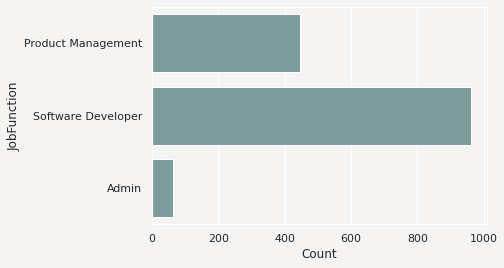

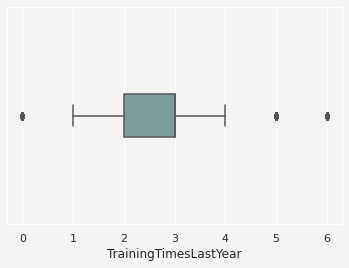

In [30]:
df.ads.feature_plot()

<a id="warnings"></a>
# Feature Type Warnings

Part of the exploratory data analysis (EDA) is to check the state or condition of your data. This is checking to ensure that there are no missing values.  With categorical data, you often want to ensure that the cardinality is low enough for the type of modeling that you are doing. Since the feature type system is meant to understand the nature of your data, and is an ideal mechanism to help automate the evaluation of the data. This evaluation is done by registering feature type warnings handlers with ADS.

Feature type warning handlers are functions that are built-in or user-defined. They perform an analysis of a feature to determine whether there are any data condition problems. For example, it might report that a feature is skewed when the expectation is that the data is normally distributed. Another common example is that the data might have more than some threshold of missing values. ADS comes with various common warnings built-in for the feature types that it supports. However, you are able to create and register any warnings that you want.

Feature type warnings are defined at the feature type level. Warnings can be registered dynamically at runtime. The `feature_type_manager.warning_registered()` shows a dataframe of registered warnings of each registered feature type. The three columns of the returned dataframes are:

- `Feature Type`: Feature Type class name.
- `Warning`: Warning name.
- `Handler`: Registered warning handler for that feature type.

In [31]:
feature_type_manager.warning_registered()

,Feature Type,Warning,Handler
0,continuous,missing_values,missing_values_handler
1,continuous,zeros,zeros_handler
2,continuous,skew_handler,skew_handler
3,date_time,missing_values,missing_values_handler
4,date_time,high_cardinality,high_cardinality_handler
5,category,missing_values,missing_values_handler
6,category,high_cardinality,high_cardinality_handler
7,ordinal,missing_values,missing_values_handler
8,boolean,missing_values,missing_values_handler
9,string,missing_values,missing_values_handler


<a id="validating_data"></a>
## Validating Data

The `.warning()` method runs all the data quality tests on a feature. It creates a dataframe where each row is the result of a test that generated a warning. The dataframe contains the feature and warning type that generated a warning. There is also a human-readable message that explains the warning. The metric and value columns contain information about the metric that was used and the value of that metric.

In the next cell, a set of credit card values is used as the dataset. The feature type is set to `credit_card` and the feature type warnings are reported.

In [32]:
visa = ["4532640527811543", "4556929308150929", "4539944650919740", "4485348152450846", "4556593717607190"]
amex = ["371025944923273", "374745112042294", "340984902710890", "375767928645325", "370720852891659"]
invalid = [np.nan, None, "", "123", "abc"]
series = pd.Series(visa + amex + invalid, name='creditcard')
series.ads.feature_type = ['credit_card']
series.ads.warning()

,Feature Type,Warning,Message,Metric,Value
0,credit_card,missing,2 missing values,count,2
1,credit_card,missing,13.3% missing values,percentage,13.33
2,credit_card,high-cardinality,15 unique values,count,15
3,string,missing,2 missing values,count,2
4,string,missing,13.3% missing values,percentage,13.33
5,string,high-cardinality,15 unique values,count,15


There are several things to notice about the generated dataframe. While the feature type was set to `credit_card`, the dataframe also lists `string` in the feature type column. This is because the default feature type is `string` so the feature type warning system also ran the tests for the `string` feature type.

The tuple (`credit_card`, `missing`) reports two warnings. This is because each warning can perform as many tests as it wants and reports as many warnings as required. This is also true for the (`string`, `missing`) tuple.

<a id="examining"></a>
## Examining Feature Type Warnings

Feature type warning handlers are functions that have been registered with ADS. The `.warning.registered()` method is part of the `warning` module and allows you to examine what warnings have been registered for a given feature type. 

The next cell uses the feature type manager to get a handle to the `credit_card` class. This class is an `ads.feature_engineering.feature_type.base.FeatureType` object that lists the name of the feature type warning and its handler.

In [33]:
CreditCard = feature_type_manager.feature_type_object('credit_card')
CreditCard.warning.registered()

,Warning,Handler
0,missing_values,missing_values_handler
1,high_cardinality,high_cardinality_handler


<a id="register_unregister"></a>
## Register and Unregistering a Feature Type Warning

In the <a href="#validating_data">Validating Data</a> section, a set of credit cards numbers were created. Several missing values were found by the feature type warning tests. However, there are credit card numbers that aren't not valid. The feature type warning system didn't pick up on this because there was no test for it. This problem can be solved by creating a feature type warning that detects this.


<a id="register"></a>
### Register a Feature Type Warning

This section shows you how to create a new feature type warning. The goal of this example is to create a feature type warning handler using the built-in  `.is_credit_card()` feature handler. The example also registers the handler and demonstrates that it is able to create warnings for invalid credit card numbers.

There are two steps to creating a feature type warning. The first is to write a function that accepts a Pandas series and returns a carefully crafted dataframe. If there are no warnings, then the dataframe can be empty or the handler can return `None`. The dataframe has to have the following columns:

* `Warning`: A string that describes the type of warning.
* `Message`: A human-readable message about the warning.
* `Metric`: A string that describes what is being measured.
* `Value`: The value associated with the metric.

The next cell uses the feature type warning handler, `invalid_credit_card_handler`, which uses the `.is_credit_card()` feature handler to create a binary list indicating whether the credit card number is valid or not. It then computes the number of invalid cards. If there are any invalid cards, then it creates a row in a dataframe with the relevant information. If not, it returns `None`. This example returns one row at most. However, it can return as many rows as needed. For example, it could return a row for each credit card that is invalid and provide the credit card number.

In [34]:
def invalid_credit_card_handler(x: pd.Series):
    value = len(x) - CreditCard.validator.is_credit_card(x).sum()
    if value > 0:
        df = pd.DataFrame(columns=['Warning', 'Message', 'Metric', 'Value'])
        df.Value = [value]
        df.Warning = ['invalid credit card count']
        df.Message = [f'{df.Value.values[0]} invalid credit cards']
        df.Metric = ['count']
        return df

Feature type warnings are registered with the feature type of interest. You can assign the same handler to multiple feature types. In this example, the feature type manager is used to get a handle to the `credit_card` class, which is an `ads.feature_engineering.feature_type.base.FeatureType` class. The  `.register()` method in the `warning` module registers the handler for the warning. You give it a name for the handler and the handler function. The optional `replace = True` parameter overwrites the handler when the name exists.

In [35]:
CreditCard = feature_type_manager.feature_type_object('credit_card')
CreditCard.warning.register(name='invalid_credit_card', 
                            handler=invalid_credit_card_handler, 
                            replace=True)

Using the `.registered()` method in the `warning` module, you can see that the `invalid_credit_card` handler has been registered:

In [36]:
CreditCard.warning.registered()

,Warning,Handler
0,missing_values,missing_values_handler
1,high_cardinality,high_cardinality_handler
2,invalid_credit_card,invalid_credit_card_handler


Run the `.warning()` method on the feature to show the updated warnings. Notice the `invalid credit card count` in the warning column:

In [37]:
series.ads.warning()

,Feature Type,Warning,Message,Metric,Value
0,credit_card,missing,2 missing values,count,2
1,credit_card,missing,13.3% missing values,percentage,13.33
2,credit_card,high-cardinality,15 unique values,count,15
3,credit_card,invalid credit card count,5 invalid credit cards,count,5
4,string,missing,2 missing values,count,2
5,string,missing,13.3% missing values,percentage,13.33
6,string,high-cardinality,15 unique values,count,15


<a id="unregister"></a>
### Unregister a Feature Type Warning

You can remove a feature type warning from a feature type using the `.unregister()` method of the `warning` module. It accepts the name of the feature type warning. If the warning doesn't exist, it return a `WarningNotFound` exception.

The next cell removes the `high-cardinality` warning and the remaining feature type warnings are displayed

In [38]:
CreditCard.warning.unregister('high_cardinality')
CreditCard.warning.registered()

,Warning,Handler
0,missing_values,missing_values_handler
1,invalid_credit_card,invalid_credit_card_handler


<a id="dataframe"></a>
## Working with a DataFrame

While working with a Pandas series can be powerful, it is often more convenient to check for warnings on an entire dataframe. This section uses the orcl_attrition.csv dataset to look at dataframe level operations that you can perform with the feature type warning tools.

The next cell loads the sample dataset:

In [39]:
attrition_path = os.path.join('/opt', 'notebooks', 'ads-examples', 'oracle_data', 'orcl_attrition.csv')
df = pd.read_csv(attrition_path, 
                 usecols=['Age', 'Attrition', 'JobFunction', 'EducationalLevel', 'EducationField', 
                          'Gender', 'JobRole','MonthlyIncome'
                          ])
df.head()

,Age,Attrition,JobFunction,EducationalLevel,EducationField,Gender,JobRole,MonthlyIncome
0,42,Yes,Product Management,L2,Life Sciences,Female,Sales Executive,5993
1,50,No,Software Developer,L1,Life Sciences,Male,Research Scientist,5130
2,38,Yes,Software Developer,L2,Other,Male,Laboratory Technician,2090
3,34,No,Software Developer,L4,Life Sciences,Female,Research Scientist,2909
4,28,No,Software Developer,L1,Medical,Male,Laboratory Technician,3468


The `.feature_type` property accepts a dictionary where the keys are the column names and the values are a list of the feature types that are to be assigned to each column. Only the columns you want to update are needed in the dictionary.

In [40]:
df.ads.feature_type = {'Age': ['integer'],
                       'Attrition': ['boolean', 'category', Tag('target')],
                       'JobFunction': ['category'],
                       'EducationalLevel': ['category'],
                       'EducationField': ['category'],
                       'Gender': ['category'],
                       'JobRole': ['category'],
                       'MonthlyIncome': ['continuous']}
df.ads.feature_type

{'Age': ['integer'],
 'Attrition': ['boolean', 'category', 'string', 'target'],
 'JobFunction': ['category', 'string'],
 'EducationalLevel': ['category', 'string'],
 'EducationField': ['category', 'string'],
 'Gender': ['category', 'string'],
 'JobRole': ['category', 'string'],
 'MonthlyIncome': ['continuous', 'integer']}

The `.warning_registered()` method on the dataframe shows all of the feature type warnings for all of the columns in the dataframe:

In [41]:
df.ads.warning_registered()

,Column,Feature Type,Warning,Handler
0,Age,integer,missing_values,missing_values_handler
1,Age,integer,zeros,zeros_handler
2,Attrition,boolean,missing_values,missing_values_handler
3,Attrition,category,missing_values,missing_values_handler
4,Attrition,category,high_cardinality,high_cardinality_handler
5,Attrition,string,missing_values,missing_values_handler
6,Attrition,string,high_cardinality,high_cardinality_handler
7,JobFunction,category,missing_values,missing_values_handler
8,JobFunction,category,high_cardinality,high_cardinality_handler
9,JobFunction,string,missing_values,missing_values_handler


The method `.warning()` on the dataframe shows all of the warnings for all of the columns in the dataframe. This is a quick way to see all of your data with a single command.

In [42]:
df.ads.warning()

,Column,Feature Type,Warning,Message,Metric,Value
0,MonthlyIncome,continuous,skew,1.370 skew,skew,1.37


<a id="overview"></a>
# Feature Type Validators

One aspect of exploratory data analysis (EDA) is to ensure that all the data is valid. For example, you may have credit card data and want to ensure that all the numbers are valid credit card numbers. The feature type validators are a way of performing this validation. There are built-in methods for the feature types that are provided by `ADS`, but the idea is for you to create these methods for your custom feature types.

Feature type validators are defined on the feature type level. You can define functions that can be applied to the columns and features of the same feature type and use it across your entire organization. The feature types that are provided by `ADS` come with a default set of handlers.

The feature type validators are a set of `.is_*()` methods, where `*` is generally the name of the feature type. For example, the method `.is_credit_card()` would be called to ensure that the data are all credit card numbers. The feature type validators return a boolean pandas series, which is the length of the data. If the element meets the criteria specified in the feature type validator, it indicates `True` otherwise it is `False`. The `.is_*()` method is called the **validator**.

The feature type validator system is extensible. You can have multiple validators for any feature type. For example, if you had a credit card feature type you may want to have the validator `.is_credit_card()`. It would check a set of credit card numbers to make sure that they are valid credit card numbers. You may want to add other validators like, `.is_visa()` and `.is_mastercard()`, to determine if the credit card numbers are associated with Visa or Mastercard accounts.

The feature type validator can also be extended through the use of conditions. Conditions allow you to have different sets of feature type validators based on a set of arguments that you define called **conditions**. For example, if you wanted to and see if a credit card is a Visa card you could create a condition like `.is_credit_card(card_type='Visa')`. Then you register a feature handler with that condition and it runs when you pass in that condition.

<a id="list_validators"></a>
## List Feature Type Validators

To make the association between the feature type, validator, condition, and feature type validator, the feature type validator must be registered with the feature type manager. The module `feature_type_manager` is used to manage these relationships.

<a id="list_validators_ftm"></a>
### List Feature Type Validators Using the Feature Type Manager

To list the current feature handlers and their conditions use the `feature_type_manager.validator_registered()` method. It shows the registered handlers in a dataframe format. The columns in the dataframe are:
- `Feature Type`: Feature type class name.
- `Validator`:    Validation functions that you can call to validate a pandas series.
- `Condition`:    Condition that the handler is registered in.
- `Handler`:      Registered handler.

In [43]:
feature_type_manager.validator_registered()

,Feature Type,Validator,Condition,Handler
0,date_time,is_datetime,(),default_handler
1,boolean,is_boolean,(),default_handler
2,string,is_string,(),default_handler
3,lat_long,is_lat_long,(),default_handler
4,phone_number,is_phone_number,(),default_handler
5,zip_code,is_zip_code,(),default_handler
6,credit_card,is_credit_card,(),default_handler
7,address,is_address,(),default_handler
8,gis,is_gis,(),default_handler
9,ip_address_v4,is_ip_address_v4,(),default_handler


<a id="list_validators_fto"></a>
### List Feature Type Validators on a Feature Type Object

Each feature type object also has a `.validator.registered()` method that returns a dataframe with the validators, conditions, and feature type validators that are associated with the given feature type. 

The next cell uses the feature type manager to obtain a `FeatureType` object for the credit card feature type. This object is the feature type object for the credit card feature type. The cell then obtains a list of validators, conditions, and feature type validators that are associated with the credit card feature type.

In [44]:
CreditCard = feature_type_manager.feature_type_object('credit_card')
CreditCard.validator.registered()

,Validator,Condition,Handler
0,is_credit_card,(),default_handler


<a id="list_validators_series"></a>
### List Feature Type Validators on a Series

The `.validator_registered()` method can be used on a pandas series by calling `.ads.validator_registeres()`.

The next cell creates a series that contains valid credit card numbers. The series has its feature type set to `credit_card`. The call to `series.ads.validator_registered()` reports multiple handlers because the series has multiple feature types associated with it (credit card and string).

In [45]:
series = pd.Series(["4532640527811543", "4556929308150929", "4539944650919740"], name='creditcard')
series.ads.feature_type = ['credit_card']
series.ads.validator_registered()

,Feature Type,Validator,Condition,Handler
0,credit_card,is_credit_card,(),default_handler
1,string,is_string,(),default_handler


<a id="list_validators_df"></a>
### List Feature Type Validators on a Dataframe

Like a pandas series, `.validator_registered()` can be used on a dataframe to obtain information on the feature type validators that are associated with the columns of the dataframe. It only displays columns that have feature type validators associated with them.

The next cell loads a sample dataset into a pandas dataframe. The feature types are then assigned to these columns and `.ads.validator_registered()` is called on the dataframe.

In [46]:
df.ads.validator_registered()

,Column,Feature Type,Validator,Condition,Handler
0,Attrition,boolean,is_boolean,(),default_handler
1,Attrition,string,is_string,(),default_handler
2,JobFunction,string,is_string,(),default_handler
3,EducationalLevel,string,is_string,(),default_handler
4,EducationField,string,is_string,(),default_handler
5,Gender,string,is_string,(),default_handler
6,JobRole,string,is_string,(),default_handler


<a id="using_handlers"></a>
## Using Feature Type Validators

The goal of the feature type validator is to validate the data against some set of criteria. This can be done using the feature type object itself or on a pandas series.

<a id="using_handlers_series"></a>
### Using Feature Type Validators on a Series

For a pandas series, the feature type validator is invoked by using the name of the validator and any condition arguments that may be required. To do this the series object calls `.ads` followed by a call to the validator name. For example, `series.ads.validator.is_credit_card(starts_with='4')`, where `.is_credit_card()` is the validator name and `starts_with='4'` is the condition.

The next cell creates a pandas series that contains a set of valid credit card numbers along with a set of invalid numbers. This series has its feature type set to `credit_card` and invokes the `.is_credit_card()` feature type validator.

In [47]:
visa = ["4532640527811543", "4556929308150929", "4539944650919740", "4485348152450846", "4556593717607190"]
invalid = [np.nan, None, "", "123", "abc"]

series = pd.Series(visa + invalid, name='creditcard')
series.ads.feature_type = ['credit_card']
series.ads.validator.is_credit_card()

0     True
1     True
2     True
3     True
4     True
5    False
6    False
7    False
8    False
9    False
Name: creditcard, dtype: bool

A series can have multiple feature types handlers associated with it. In this example, `.is_string()` could have also been called. Since the return type is a pandas series the `.any()` and `.all()` methods can be used to provide summary information about the validation. 

The next cell shows you how to validate that there is at least one datum that is not a valid string.

In [48]:
series.ads.validator.is_string().all()

False

<a id="using_handlers_fto"></a>
### Using Feature Type Validators on a Feature Type Object

A feature type object can be used to invoke the feature type validator by using the name of the validator and any condition arguments that may be required on the feature type object. On the feature type object, call the validator. For example, `CreditCard.is_credit_card(starts_with='4')`, where `.is_credit_card()` is the validator and `starts_with='4'` is the condition.

The next cell uses the feature type manager to obtain a feature type object to the credit card feature type. This object is used to call the feature type validator by passing in the pandas series that is to be assessed.

In [49]:
CreditCard = feature_type_manager.feature_type_object('credit_card')
CreditCard.validator.is_credit_card(series)

0     True
1     True
2     True
3     True
4     True
5    False
6    False
7    False
8    False
9    False
Name: creditcard, dtype: bool

<a id="default_handler"></a>
## Default Feature Type Validator

The power of the feature type system is that you can quickly create new feature type validators to validate your data. This is a two step process:

1. Define a function that will act as the feature type validator.
1. Register the feature type validator.

Each feature type has a default handler that is called when no other handler can process a request.

<a id="create_handler"></a>
### Create a Default Feature Type Validator

A feature type validator is a function that respects these rules:

* It takes a series as a first argument.
* If there are any condition arguments, the `*args` and `**kwargs` should be used.
* It returns a boolean series that is the same length as the input series.

To register your own handler, you need to define the handler and then register it to the feature type. If the handler already exists, there is no need to create a new one.

In this example a new feature type validator, `.is_visa_card_handler()`, is created. It checks to see if the credit card number is issued by Visa. The next cell creates the `is_visa_card_handler()` function that tests each element in the `data` parameter is a valid Visa credit card number. Then it returns a boolean series the same length as `data`.

In [50]:
def is_visa_card_handler(data: pd.Series, *args, **kwargs) -> pd.Series:
    """
    Processes given data and indicates if the data matches Visa credit card.

    Parameters
    ----------
    data: pd.Series
        The data to process.

    Returns
    --------
    pd.Series: The logical list indicating if the data matches requirements.
    """
    _pattern_string = r"""
        ^(?:4[0-9]{12}(?:[0-9]{3})?         # Visa
        |  ^4[0-9]{12}(?:[0-9]{6})?$        # Visa 19 digit
        )$
    """
    PATTERN = re.compile(_pattern_string, re.VERBOSE)
    def _is_credit_card(x: pd.Series):
        return (
            not pd.isnull(x)
            and PATTERN.match(str(x)) is not None
        )
    return data.apply(lambda x: True if _is_credit_card(x) else False)

<a id='validator_register'></a>
### Registering a Default Feature Type Validator

The feature type validator, needs to be registered with the feature type. You do that using the `.register()` method, which is part of the feature type object. The feature type manager is used to obtain a link to the feature type object.


The `.register()` method has the following parameters:
- `name`: The validator name that is used to invoke the feature type validator.
- `handler`: The function name of the default feature type validator.
- `replace`: The flag indicating if the registered handler should be replaced with the new one.

The next cell obtains the feature type object, `CreditCard`, and then it registers the default feature type validator. If one exists, with the same name, it is replaced. A call to `CreditCard.validator_registered()` returns the registered handlers for the credit card feature type.

In [51]:
CreditCard = feature_type_manager.feature_type_object('credit_card')
CreditCard.validator.register(name='is_visa_card', handler=is_visa_card_handler, replace = True)
CreditCard.validator.registered()

,Validator,Condition,Handler
0,is_credit_card,(),default_handler
1,is_visa_card,(),is_visa_card_handler


The next cell demonstrates how to use the `.is_visa_card()` feature type validator. A series is created that contains credit cards from Visa, Mastercard and American Express. The `.is_visa_card()` feature type validator is called and it returns a boolean series indicating which credit cards are issued by Visa.

In [52]:
visa = ["4532640527811543", "4556929308150929"]
mastercard = ["5406644374892259", "5440870983256218"]
amex = ["371025944923273", "374745112042294"]
series = pd.Series(visa + mastercard + amex, name='Credit Card')
series.ads.feature_type = ['credit_card']
CreditCard.validator.is_visa_card(series)

0     True
1     True
2    False
3    False
4    False
5    False
Name: Credit Card, dtype: bool

<a id='condition_handler'></a>
## Condition Feature Type Validator

Each feature type validator has a default handler that is called when no condition handler can handle a request. A condition feature type validator allows you to specify arbitrary parameters that are passed to the feature type system. The system examines these parameters and determines the best handler that should be dispatched. This determination is done by using the most restrictive set of parameter criteria.

Use the `.register()` method to register a condition handler. The parameter `name` gives a user-friendly name to the registered handler. The `condition` parameter is used to specify the conditions that must be met to invoke the handler. Conditions would be user-defined parameters and values that help identify what condition in which the handler is to be dispatched. The `handler` parameter is the name of a function that will be dispatched when the conditions are met. The parameter `replace` determines if the handler should replace one that matches the condition. If set to `True` it will replace it if it exists. If set to `False` it will not replace an existing matching handler and will throw an error.

A feature type validator is a function that respects the following rules:

* It takes a series as a first argument.
* It has formal arguments for the conditions.
* It returns a boolean series that is the same length as the input series.

<a id='condition_handler_closed'></a>
### Closed Value Condition Feature Type Validator

Closed value condition feature types allow you to specify any number of key-pair pairs to a condition handler and control which feature type validator is dispatched. However, when calling the handler, all of the key-value pairs must match.

The `condition` parameter of the `.register()` method can explicitly define key-value pairs that are used to determine with handler to dispatch. In the <a href="#default_handler">Default Feature Type Validator</a> section, the `is_visa_card` validator was created to determine if the credit cards were issued by Visa. It is possible to create the same effect by using a condition feature type validator on the `is_credit_card` feature type handle using explicit key-value pairs. To do this, the `condition` method accepts a dictionary of key-value pairs where the key is the parameter name and the dictionary value is the parameter value. For example, `CreditCard.validator.register(name='is_credit_card', condition={"card_type": "Visa"}, handler=is_visa_card_handler, replace=True)` links the parameter `card_type` to the value `Visa`.

In the next cell, the credit card feature type has a condition handler registered. It uses the same feature type validator, `is_visa_card_handler` that was used to create the `is_visa_card` default feature type validator.

In [53]:
CreditCard = feature_type_manager.feature_type_object('credit_card')
CreditCard.validator.register(name='is_credit_card', condition={"card_type": "Visa"}, handler=is_visa_card_handler, replace=True)
CreditCard.validator.registered()

,Validator,Condition,Handler
0,is_credit_card,(),default_handler
1,is_credit_card,{'card_type': 'Visa'},is_visa_card_handler
2,is_visa_card,(),is_visa_card_handler


The next cell creates a series of credit card numbers and uses the parameters `card_type="Visa"` when calling the `is_credit_card` validator. Notice that only the first two elements are flagged as being issued by Visa. If the default handler was called, all the returned values would have been `True` because they are all valid credit card numbers.

In [54]:
visa = ["4532640527811543", "4556929308150929"]
mastercard = ["5406644374892259", "5440870983256218"]
amex = ["371025944923273", "374745112042294"]
series = pd.Series(visa + mastercard + amex, name='Credit Card')
series.ads.feature_type = ['credit_card']
CreditCard.validator.is_credit_card(series, card_type="Visa")

0     True
1     True
2    False
3    False
4    False
5    False
Name: Credit Card, dtype: bool

The previous cell called the feature type validator using the feature type object, `CreditCard`. It can also be called using the pandas series.

In [55]:
series.ads.validator.is_credit_card(card_type="Visa")

0     True
1     True
2    False
3    False
4    False
5    False
Name: Credit Card, dtype: bool

With closed value condition feature type validators, the key and values must match what was registered. If they don't, the condition feature type validator isn't called. In the next cell, the value is set to `Mastercard` to cause the default handler to be called. 

In [56]:
CreditCard.validator.is_credit_card(series, card_type="Mastercard")

0    True
1    True
2    True
3    True
4    True
5    True
Name: Credit Card, dtype: bool

To register a closed value feature type validator that has multiple conditions, you use a dictionary with multiple key-value pairs. For example, to create a condition that checks that the country code is 1 and area code is 902, you could do the following:

```python
PhoneNumber.validator.register(name='is_phone_number', condition={"country_code": "1", "area_code": "902"},
                               handler=is_1_902_handler)
```

<a id='condition_handler_open'></a>
### Open Value Condition Feature Type Validator

Open value condition feature type validators are similar to their closed value counterparts expect the value is not used in the matching process.

To register an open value condition feature type validator, the same process is used as for the <a href='#condition_handler_closed'>Closed Value Condition Feature Type Validator</a> with the exception that a tuple is used to specify the conditions and no values are provided. For example, `CreditCard.validator.register(name='is_credit_card', condition=("card_type",), handler=is_any_card_handler)`.

The next cell defines a feature type condition handler that accepts the card type as a parameter name:

In [57]:
def is_any_card_handler(data: pd.Series, card_type: str) -> pd.Series:
    """
    Processes given data and indicates if the data matches any credit card

    Parameters
    ----------
    data: pd.Series
        The data to process.

    Returns
    --------
    pd.Series: The logical list indicating if the data matches requirements.
    """
    
    if card_type == 'Visa':
        _pattern_string = r"""
            ^(?:4[0-9]{12}(?:[0-9]{3})?         # Visa
            |  ^4[0-9]{12}(?:[0-9]{6})?$        # Visa 19 digit
            )$
        """    
    elif card_type == 'Mastercard':
        _pattern_string = r"""
            ^5[1-5][0-9]{14}|^(222[1-9]|22[3-9]\\d|2[3-6]\\d{2}|27[0-1]\\d|2720)[0-9]{12}$
        """
        
    elif card_type == "Amex":
        _pattern_string = r"""
            ^3[47][0-9]{13}$
        """
    else:
        raise ValueError()
        
    PATTERN = re.compile(_pattern_string, re.VERBOSE)
    def _is_credit_card(x: pd.Series):
        return (
            not pd.isnull(x)
            and PATTERN.match(str(x)) is not None
        )
    return data.apply(lambda x: _is_credit_card(x))

The next cell registers the open value feature type validator using a tuple. Notice that values for the `card_type` parameter aren't specified. However, the `is_any_card_handler` function has a formal argument for it. The value of the parameter is passed into the handler. Also, note the trailing comma to make the parameter in `condition` a tuple. This forces Python to make `('card_type',)` a tuple. The output of the cell is the currently registered feature type validators.

In [58]:
CreditCard.validator.register(name='is_credit_card', condition=("card_type",), handler=is_any_card_handler)
CreditCard.validator.registered()

,Validator,Condition,Handler
0,is_credit_card,(),default_handler
1,is_credit_card,{'card_type': 'Visa'},is_visa_card_handler
2,is_credit_card,"('card_type',)",is_any_card_handler
3,is_visa_card,(),is_visa_card_handler


To determine which credit card numbers in the variable `series` are issued by Mastercard, pass the parameter `card_type="Mastercard"` into the `.is_credit_card()` feature type validator. The feature type system examines the parameters and then dispatches `is_any_card_handler`. `is_any_card_handler` accepts the `card_type` parameter and has logic to detect which numbers are Mastercard.

In [59]:
series.ads.validator.is_credit_card(card_type="Mastercard")

0    False
1    False
2     True
3     True
4    False
5    False
Name: Credit Card, dtype: bool

This approach can also be used by the feature type object, `CreditCard`. In this example, the values in the variable `series` are checked to see if they match American Express credit card numbers:

In [60]:
CreditCard.validator.is_credit_card(series, card_type="Amex")

0    False
1    False
2    False
3    False
4     True
5     True
Name: Credit Card, dtype: bool

To register an open value feature type validator that has multiple conditions, you would use a tuple with multiple values. For example, if you wanted to create a condition that would check the country and area codes of a phone number, you could use the following:

```python
PhoneNumber.validator.register(name='is_phone_number', condition=(("country_code", "area_code")),
                               handler=is_county_area_handler)
```

It's not possible to mix open and closed condition feature type validators.

<a id='condition_handler_disambiguation'></a>
### Disambiguation

In this notebook, a closed condition feature type was created for `'card_type'='Visa'`. There was also an open condition feature type that was created to handle all conditions that specify the `card_type` parameter. There appears to be a conflict in that both conditions support the case of `'card_type'='Visa'`. In fact, there is no conflict. The feature type system determines the most restrictive case and dispatches on it so the `is_visa_card_handler` handler is called.

In [61]:
CreditCard.validator.registered()

,Validator,Condition,Handler
0,is_credit_card,(),default_handler
1,is_credit_card,{'card_type': 'Visa'},is_visa_card_handler
2,is_credit_card,"('card_type',)",is_any_card_handler
3,is_visa_card,(),is_visa_card_handler


The next cell causes the `is_visa_card_handler` to be dispatched because it has the most restrictive set of requirements that match the parameters given.

In [62]:
series.ads.validator.is_credit_card(card_type="Visa")

0     True
1     True
2    False
3    False
4    False
5    False
Name: Credit Card, dtype: bool

<a id='unregistering'></a>
## Unregistering a Feature Type Validator

The `.unregister()` method is used to remove a feature type validator. Condition feature type validators are removed by using the validator as an accessor. In this case, the parameters to `.unregister()` are a dictionary in the case of closed condition feature type validators and it must match the dictionary that was used to register the handler. In the case of the open condition feature type validator, a tuple is passed to the `.unregister()`. Again, the tuple must match the tuple that was used to register the handler.

To remove a default feature type validator, use the feature type object along with the `.unregister()` method. In this case, the parameter is the name of the validator. Removing the default feature type validator also removes any condition feature type validators that are associated with it.

The next cell lists the current feature type validators.

In [63]:
CreditCard = feature_type_manager.feature_type_object('credit_card')
CreditCard.validator.registered()

,Validator,Condition,Handler
0,is_credit_card,(),default_handler
1,is_credit_card,{'card_type': 'Visa'},is_visa_card_handler
2,is_credit_card,"('card_type',)",is_any_card_handler
3,is_visa_card,(),is_visa_card_handler


Remove the closed condition for the case where `'card_type'='Visa'` on the validator `is_credit_card` as in the next cell. Note that the handler has been removed.

In [64]:
try:
    CreditCard.validator.unregister(name="is_credit_card", condition = {"card_type": "Visa"})
except:
    pass
CreditCard.validator.registered()

,Validator,Condition,Handler
0,is_credit_card,(),default_handler
1,is_credit_card,"('card_type',)",is_any_card_handler
2,is_visa_card,(),is_visa_card_handler


Remove the open condition for `card_type` on the validator `is_credit_card` as in the next cell. Note that the handler has been removed.

In [65]:
CreditCard.validator.unregister(name="is_credit_card", condition=("card_type",))
CreditCard.validator.registered()

,Validator,Condition,Handler
0,is_credit_card,(),default_handler
1,is_visa_card,(),is_visa_card_handler


Remove the default feature type validator for `is_visa_card` as in the next cell. Note that the handler has been removed.

In [66]:
CreditCard.validator.unregister(name='is_visa_card')
CreditCard.validator.registered()

,Validator,Condition,Handler
0,is_credit_card,(),default_handler


<a id="feature_type_create"></a>
# Create a Custom Feature Type

The feature type framework comes with some common feature types. However, the power of using feature types is that you can easily create your own, and apply them to your specific data. You don't need to try to represent your data in a synthetic way that does not match the nature of your data. This framework allows you to create methods that validate whether the data fits the specifications of your organization.

To create a custom feature type, you need to create a class that is inherited from the `FeatureType` class. The class must be registered with ADS before it can be used. You do this using the `feature_type_manager.feature_type_register()` method and pass in the name of the class.

In the next cell, the custom feature type, `CustomCreditCard`, is created and is inherited from the `FeatureType` base class. The class overrides the `name` attribute to set a custom name for the class. If it is not overridden then the name will automatically be determined by the class name and converted to snake case. The name can be used to register and unregister a class. It is also used in several outputs to identify the class. When assigning a feature type to a series, the name can be used to identify the class.

The `description` attribute allows you to provide detailed information about a feature type. If it is not overridden the description will default to 'Base Feature Type.'

The `.feature_stat()` provides a mechanism to provide summary statistics for a feature type. If this method is not overridden and `.feature_stat()` is called on a feature type the multiple inheritance mechanism will be used. For example, we may create a feature type called `wholesale_price` and then a Pandas series called `car_price`. `car_price` has the following feature types: `wholesale_price`, `car_price`, `USD`, and `continuous`. Assuming that `.feature_stat()` is not overridden in the `wholesale_price` class, the system will attempt to generate the feature statistics using the `.feature_stat()` method defined in its parent feature type, `car_price`. This will continue until a feature type has defined the `.feature_stat()` method. If none of the custom feature type classes implement `.feature_stat()` it will fall through to the default feature type which always has this method implemented.

In the next cell, the `.feature_stat()` method is implemented. It will create a dataframe where the index is the name of the metric. There will be one column that is the value that is associated with the metric.

The `.feature_plot()` method can be overridden such that a custom plot can be created for the data. Just like the `.feature_stat()` method, if it is not overridden a plot will be generated by the multiple inheritance mechanism. All default feature types have a defined `.feature_plot()`. Since the default feature type's plotting method is generic, it may or may not provide a good representation of the data.

In the next cell, the `.feature_plot()` method creates a bar chart with the count of the issuing financial institution. 


As with all classes, it is possible to add additional attributes and methods that may be helpful when working with a feature type. The next cell implements a method called `.issuer()`. Since the class that we are creating is a custom credit card, this would be a handy piece of information.

The important rule is that all methods of the feature type must be `static` or `class` level methods and should take a Pandas series as a first argument.

In [67]:
def assign_issuer(cardnumber):
    """
    Identifies the credit card type.
    """
    if pd.isnull(cardnumber):
        return "missing"
    else:
        return card_identify().identify_issue_network(cardnumber)

class CustomCreditCard(FeatureType):
    """Type representing custom credit card numbers.

    Attributes
    ----------
    description: str
        The feature type description.
    name: str
        The feature type name.
    
    Methods
    --------
    register_handler(cls, name: str, default_handler: Callable) -> None
        Registers a new handler for a feature type.
    unregister_handler(cls, name: str) -> None
        Unregisters a handler.
    registered_handlers(cls) -> pd.DataFrame
        Gets the list of registered handlers.
    feature_stat(x: pd.Series) -> pd.DataFrame
        Generates feature statistics.        
    feature_plot(x: pd.Series) -> plt.Axes
        Generates plot object.
    """
    description = "This is an example of a custom credit card feature type."
    name="Custom Credit Card"
       
    @staticmethod
    def issuer(series: pd.Series) -> pd.Series:
        """Identifies the credit card type.
        
        Parameters
        ----------
        series: pd.Series
            The data to process.
        
        Returns
        -------
        pd.Series: The result of processing data.
        """
        return series.apply(lambda card_number: 'Missing'
                       if pd.isnull(card_number) else card_identify().identify_issue_network(card_number))    
    
    @staticmethod
    def feature_stat(series: pd.Series) -> pd.DataFrame:
        """Generates feature statistics.

        Feature statistics include (total)count, unique(count), missing(count) and
            count of each credit card type.
        
        Parameters
        ----------
        series: pd.Series
            The data to process.

        Returns
        -------
        Pandas Dataframe
            Summary statistics of the Series or Dataframe provided.
        """
        
        def _count_unique_missing(series: pd.Series):
            """Return the total count, unique count and count of missing values of a series."""

            def _add_missing(series, df):
                """Add count of missing values."""
                n_missing = pd.isnull(series.replace(r'', np.NaN)).sum()
                if n_missing > 0:
                    df.loc['missing'] = n_missing
                return df

            df_stat = pd.Series({'count': len(series),
                                 'unique': len(series.replace(r'', np.NaN).dropna().unique())},
                                name=series.name).to_frame()
            return _add_missing(series, df_stat)

        df_stat = _count_unique_missing(series)
        card_types = series.apply(assign_issuer)
        value_counts = card_types.value_counts()
        value_counts.index = [
            "count_" + cardtype for cardtype in list(value_counts.index)
        ]
        return pd.concat([df_stat, value_counts.to_frame()])
    
    @staticmethod
    def feature_plot(x: pd.Series) -> plt.Axes:
        """Generates plot object.

        Bar plot include present count of each credit card type.
        
        Parameters
        ----------
        series: pd.Series
            The data to process.

        Returns
        -------
        matplotlib.axes._subplots.AxesSubplot
            Plot object for the series based on the CreditCard feature type.
        """
        card_types = x.apply(assign_issuer)
        df = card_types.value_counts().to_frame()
        if len(df.index):
            ax = sns.barplot(x=df.index, y=list(df.iloc[:, 0]), color='#76A2A0')
            ax.set(xlabel="Issuing Financial Institution")
            ax.set(ylabel="Count")
            return ax

<a id="feature_type_register"></a>
## Register a Custom Feature Type

To create a custom feature type, you need to create a class that is inherited from the `FeatureType` class. The class must be registered with ADS before it can be used. You do this using the `feature_type_manager.feature_type_register()` method and pass in the name of the class.

Once the feature type class has been created, it must be registered with ADS using the `feature_type_manager.feature_type_register()` method. The next cell registers the `CustomCreditCard` and displays all feature types.

In [68]:
try:
    feature_type_manager.feature_type_register(CustomCreditCard)
except:
    pass
feature_type_manager.feature_type_registered()

,Class,Name,Description
0,ADSString,ads_string,Type representing enhanced string class.
1,Address,address,Type representing address.
2,Boolean,boolean,Type representing binary values True/False.
3,Category,category,Type representing discrete unordered values.
4,Constant,constant,Type representing constant values.
5,Continuous,continuous,Type representing continuous values.
6,CreditCard,credit_card,Type representing credit card numbers.
7,CustomCreditCard,Custom Credit Card,This is an example of a custom credit card feature type.
8,DateTime,date_time,Type representing date and/or time.
9,Discrete,discrete,Type representing discrete values.


<a id="feature_type_attributes"></a>
## Attributes

The attributes `name` and `description` can be accessed in the standard method that the attributes of any class can be accessed. 

The name assigned to the `CustomCreditCard` class can be determined by calling `CustomCreditCard.name`.

In [69]:
CustomCreditCard.name

'Custom Credit Card'

The same approach works for the `description` attribute.

In [70]:
CustomCreditCard.description

'This is an example of a custom credit card feature type.'

<a id="feature_type_stats"></a>
## Feature Type Statistics

The `.feature_stat()` method is used to provide summary statistics about a Pandas series that are specific for the feature type. In the `CustomCreditCard` class, the summary statistics were count, unique credit card numbers, the number of missing values and the number of credit cards from each issuer. The power of the feature type statistic is that you can create any number of summary statistics that will adequately summarize your feature type.

The summary statistics can be accessed by calling `.feature_stat()` on a series using the feature type class. The next cell creates a dataframe of credit cards and uses this approach to output the summary statistics.

In [71]:
creditcard_numbers = ["4532640527811543", "4556929308150929", "4539944650919740", "4485348152450846", "4556593717607190",
                       "5406644374892259", "5440870983256218", "5446977909157877", "5125379319578503", "5558757254105711",
                       "371025944923273", "374745112042294", "340984902710890", "375767928645325", "370720852891659",
                       np.nan, None, "", "111", "0"]
df = pd.DataFrame({'credit_card': creditcard_numbers})
CustomCreditCard.feature_stat(df['credit_card'])

,credit_card
count,20
unique,17
missing,3
count_Visa,5
count_Amex,5
count_Diners Club,4
count_Unknown,3
count_missing,2
count_MasterCard,1


The more common approach to generating summary statistics is to call `.feature_stat()` on the Pandas series itself. Before doing this, the series needs to be associated with the feature type 'Custom Credit Card'. The next cell makes `df['credit_card']` have the feature type 'Custom Credit Card' and then displays the summary statistics.

In [72]:
df['credit_card'].ads.feature_type = ['Custom Credit Card']
df['credit_card'].ads.feature_stat()

,Metric,Value
0,count,20
1,unique,17
2,missing,3
3,count_Visa,5
4,count_Amex,5
5,count_Diners Club,4
6,count_Unknown,3
7,count_missing,2
8,count_MasterCard,1


<a id="feature_type_plot"></a>
## Feature Type Plot

The `.feature_plot()` method is used to provide a univariate plot that is specific to a feature type.  You can create your own plot that will visualize your feature type. For the CustomCreditCard feature type, a bar chart was implemented in the `.feature_plot()` method. It counts the number of credit cards based on the issuing financial institution. It then sorts the counts from highest to lowest. The method returns a Seaborn plot object that can then be customized.

The plot method can be accessed by calling `.feature_plot()` on a series. The next cell creates a Seaborn plot object for the feature type Custom Credit Card.

<AxesSubplot:xlabel='Issuing Financial Institution', ylabel='Count'>

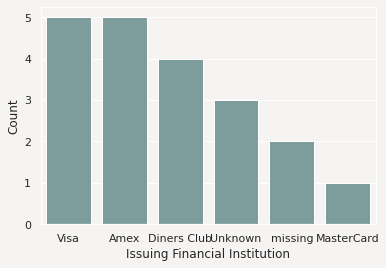

In [73]:
df['credit_card'].ads.feature_plot()

<a id="feature_type_method"></a>
## Custom Method in a Feature Type Class

It is often desirable to add methods to a feature type class that provide extra functionality when working with that feature type. In the `CustomCreditCard` class the method `.issuer()` was added. This method returns the name of the organization that issued the credit card number.

The custom method can be accessed by calling `.issuer()` on a series using the feature type class. The next uses this approach to create a series for credit card issuers. This approach has the advantage that the series, `df['credit_card']` does not have to have the feature type `CustomCreditCard`.

In [74]:
CustomCreditCard.issuer(df['credit_card'])

0            Visa
1            Visa
2            Visa
3            Visa
4            Visa
5     Diners Club
6     Diners Club
7     Diners Club
8      MasterCard
9     Diners Club
10           Amex
11           Amex
12           Amex
13           Amex
14           Amex
15        Missing
16        Missing
17        Unknown
18        Unknown
19        Unknown
Name: credit_card, dtype: object

The more common approach is to call `.issuer()` on the Pandas series itself. Before doing this, the series needs to be associated with the feature type 'Custom Credit Card'. The next cell makes `df['credit_card']` have the feature type 'Custom Credit Card' and issuer of each credit card number.

In [75]:
df['credit_card'].ads.feature_type = ['Custom Credit Card']
df['credit_card'].ads.issuer()

0            Visa
1            Visa
2            Visa
3            Visa
4            Visa
5     Diners Club
6     Diners Club
7     Diners Club
8      MasterCard
9     Diners Club
10           Amex
11           Amex
12           Amex
13           Amex
14           Amex
15        Missing
16        Missing
17        Unknown
18        Unknown
19        Unknown
Name: credit_card, dtype: object

<a id='unregister_custom_type'></a>
## Unregistering a Custom Feature Type

To unregister custom feature type the `feature_type_manager.feature_type_unregister()` method can be used for this. This method accepts either a feature type object `feature_type_manager.feature_type_unregister(CustomCreditCard)` or its name `feature_type_manager.feature_type_unregister("Custom Credit Card")`.

The next cell unregisters the `CustomCreditCard` feature type and displays the currently registered feature types. Notice that `CustomCreditCard` is not listed.

In [76]:
feature_type_manager.feature_type_unregister(CustomCreditCard)
feature_type_manager.feature_type_registered()

,Class,Name,Description
0,ADSString,ads_string,Type representing enhanced string class.
1,Address,address,Type representing address.
2,Boolean,boolean,Type representing binary values True/False.
3,Category,category,Type representing discrete unordered values.
4,Constant,constant,Type representing constant values.
5,Continuous,continuous,Type representing continuous values.
6,CreditCard,credit_card,Type representing credit card numbers.
7,DateTime,date_time,Type representing date and/or time.
8,Discrete,discrete,Type representing discrete values.
9,Document,document,Type representing document values.


<a id="reference"></a>
# References

- [ADS Library Documentation](https://docs.cloud.oracle.com/en-us/iaas/tools/ads-sdk/latest/index.html)
- [Data Science YouTube Videos](https://www.youtube.com/playlist?list=PLKCk3OyNwIzv6CWMhvqSB_8MLJIZdO80L)
- [OCI Data Science Documentation](https://docs.cloud.oracle.com/en-us/iaas/data-science/using/data-science.htm)
- [Oracle Data & AI Blog](https://blogs.oracle.com/datascience/)